<script>
    function findAncestor (el, name) {
        while ((el = el.parentElement) && el.nodeName.toLowerCase() !== name);
        return el;
    }
    function colorAll(el, textColor) {
        el.style.color = textColor;
        Array.from(el.children).forEach((e) => {colorAll(e, textColor);});
    }
    function setBackgroundImage(src, textColor) {
        var section = findAncestor(document.currentScript, "section");
        if (section) {
            section.setAttribute("data-background-image", src);
			if (textColor) colorAll(section, textColor);
        }
    }
</script>


<script>
    setBackgroundImage("firstslide1.png", "black");
</script>

In [48]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.tree import _tree
import pydotplus
from IPython.display import Image, display, clear_output
from ipywidgets import widgets, Layout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from bokeh.plotting import *
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from tabulate import tabulate
import squarify
import spacy
import string
from nltk.classify import SklearnClassifier
from subprocess import check_output
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import base64
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
import holoviews as hv
import copy
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from time import time
stopwords = stopwords.words('english')
sns.set_context('talk')

import re
#spacy.load('en')
from spacy.lang.en import English
parser = English()
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
import tabulate
from sklearn.metrics import confusion_matrix
from spacy import displacy

In [2]:
episodes= ["SW_EpisodeIV.txt","SW_EpisodeV.txt", "SW_EpisodeVI.txt"]
SW= []
star_all = pd.DataFrame()
for episode in episodes:
    star_1 = pd.read_csv(episode, sep='" "', engine='python')
    star_1 = star_1.loc[:,star_1.dtypes==object].apply(lambda star_1:star_1.str.replace('"', ""))
    star_1 = star_1.reset_index(drop=True)
    star_1.columns = ['character', 'dialogue']
    SW.append(star_1)
star_all = pd.concat(SW)
star_all = star_all.reset_index(drop=True)
star_all.shape

(2523, 2)

<script>
    setBackgroundImage("starwarslogo.png", "black");
</script>

In [3]:
star_all.character.value_counts()

LUKE                              494
HAN                               459
THREEPIO                          301
LEIA                              227
VADER                             140
BEN                               115
LANDO                             101
YODA                               49
EMPEROR                            44
RED LEADER                         38
BIGGS                              34
WEDGE                              33
PIETT                              31
TARKIN                             28
JABBA                              26
OWEN                               25
CREATURE                           22
TROOPER                            19
ACKBAR                             14
GOLD LEADER                        14
OFFICER                            13
RIEEKAN                            13
COMMANDER                          10
INTERCOM VOICE                      8
CONTROLLER                          8
RED TEN                             8
GOLD FIVE   

In [4]:
classes=star_all.character.value_counts()
classes_big=classes[classes>=40]
sufficient=star_all[star_all.character.isin(classes_big.index)][["character",'dialogue']]

In [5]:
sufficient.character.value_counts()

LUKE        494
HAN         459
THREEPIO    301
LEIA        227
VADER       140
BEN         115
LANDO       101
YODA         49
EMPEROR      44
Name: character, dtype: int64

In [6]:
sufficient=sufficient.reset_index(drop=True)
sufficient.shape

(1930, 2)

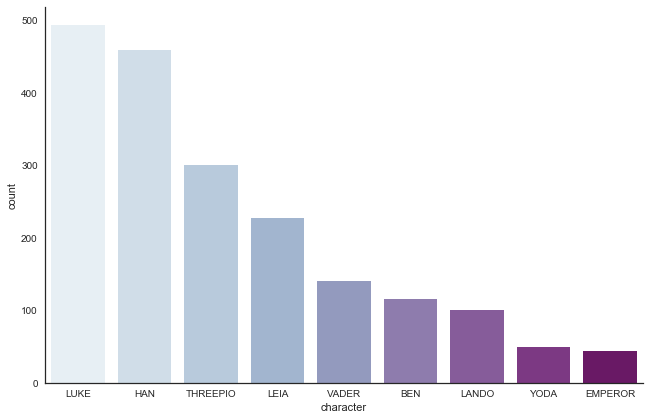

In [7]:
sns.set(style="white")
g = sns.factorplot(x="character", data=sufficient, kind="count",
                   palette="BuPu", size=6, aspect=1.5, order=list(sufficient.character.value_counts().index))

In [8]:
sufficient["tokens"]=sufficient['dialogue'].apply(word_tokenize) 

In [9]:
def no_punct(tokens):
    words = [word for word in tokens if word.isalpha()]
    return words
def to_lower(tokens):
    words = [w.lower() for w in tokens]
    return words

In [10]:
sufficient["tokens"]=sufficient['tokens'].apply(to_lower)
sufficient["tokens"]=sufficient['tokens'].apply(no_punct)

In [11]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [12]:
clean_uniques={}
for person in sufficient.character.unique():
    INFO_text = [text for text in sufficient[sufficient['character'] == person]['dialogue']]
    INFO_clean = cleanup_text(INFO_text)
    INFO_clean = ' '.join(INFO_clean).split()
    clean_uniques[person]=set(INFO_clean)

In [13]:
sns.set(style="white")
sns.set_context('talk')
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation+"..."

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

INFO_text = [text for text in sufficient[sufficient['character'] == 'LUKE']['dialogue']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()


INFO_counts = Counter(INFO_clean)

INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]



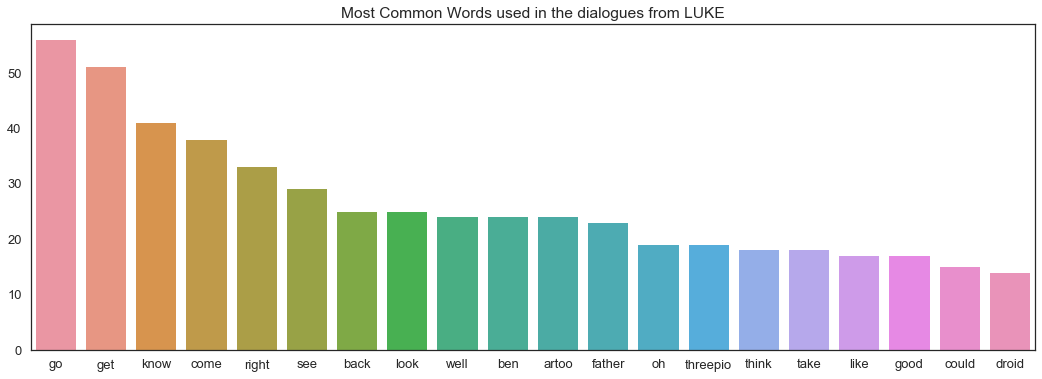

In [14]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the dialogues from LUKE')
plt.show()

In [15]:
eap = sufficient[sufficient['character'] == 'HAN']
eap_text = ' '.join(text for text in eap['dialogue'])
print('Number of words in eap_text:', len(eap_text))

Number of words in eap_text: 23023


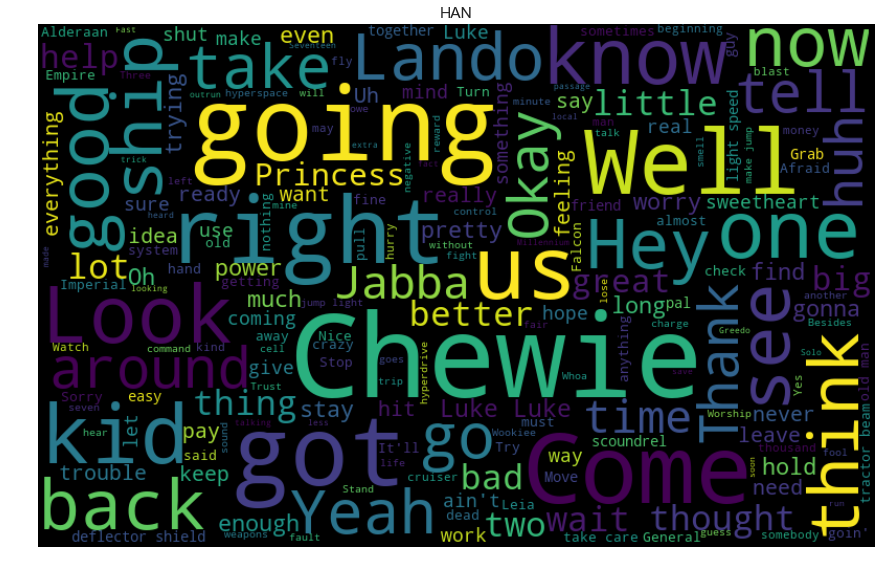

In [16]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(eap_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("HAN")
plt.axis('off')
plt.show();

In [17]:
sufficient["words"]=sufficient.tokens.apply(lambda x: len(x))

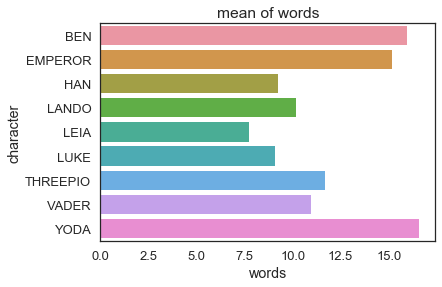

In [18]:
df = sufficient.groupby(['character'])[["words"]].mean()

ax=sns.barplot(x=df.words, y=df.index)
ax.set_title("mean of words");

In [19]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [20]:
clean_uniques={}
for person in sufficient.character.unique():
    INFO_text = [text for text in sufficient[sufficient['character'] == person]['dialogue']]
    INFO_clean = cleanup_text(INFO_text)
    INFO_clean = ' '.join(INFO_clean).split()
    clean_uniques[person]=set(INFO_clean)

In [21]:
star_chord=pd.DataFrame(columns=['source','target','value'])


In [22]:
persons_already=[]
for person in sufficient.character.unique():
    persons_already.append(person)
    for person2 in sufficient.character.unique():
        INTERSECT= len(clean_uniques[person].intersection(clean_uniques[person2])) 
        if not person2 in persons_already:
            star_chord = star_chord.append({'source': person, 'target': person2, 'value':INTERSECT}, ignore_index=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
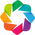

In [23]:
hv.extension('bokeh')
%output size=200

In [24]:
unique_characters=pd.DataFrame({"name":sufficient.character.unique()})
dict_characters=unique_characters.to_dict()["name"]
dict_charact={y:x for x,y in dict_characters.items()}

In [25]:
star_chord["source"]=star_chord["source"].map(dict_charact)#macht aus namen der character nummern
star_chord["target"]=star_chord["target"].map(dict_charact)#namen werden dann in nodes gespeichert

In [26]:
links = star_chord
links["value"]=pd.to_numeric(links["value"])

In [27]:
nodes = hv.Dataset(unique_characters, 'index')

In [28]:
output_notebook()

Loading BokehJS ...

# Who uses similar words?

In [29]:
%%opts Chord [label_index='name' color_index='index' edge_color_index='source'] 
%%opts Chord (cmap='Category20' edge_cmap='Category20')
hv.Chord((links, nodes)).select(value=(5, None))


:Chord   [source,target]   (value)

In [34]:
def evaluate(tokenizer, textcat, texts, cats):
    #changed to "argmax" of the scores
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]["cats"]
        
        #here: set label and score to the highest of the predictions. Compare to truth
        #Recall basically deactivated
        label, score = sorted(doc.cats.items(), key=lambda val: val[1], reverse=True)[0]
        #for label, score in doc.cats.items():
        if gold[label] >= 0.5:
            tp += 1.
        elif gold[label] < 0.5:
            fp += 1.
        #elif score < 0.5 and gold[label] < 0.5:
        #    tn += 1
        #elif score < 0.5 and gold[label] >= 0.5:
        #    fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


In [39]:
def clean_string(mystring):
    return re.sub('[^A-Za-z\ 0-9 ]+', '', mystring)




model=None#"en_core_web_lg" #included word-vectors
output_dir=""
n_iter=7
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
for i in ['THREEPIO', 'VADER', 'LUKE', 'BEN', 'LEIA', 'HAN', 'EMPEROR','YODA', 'LANDO']: #hier standen emotionen
    textcat.add_label(i)


df = sufficient

character_values = df['character'].unique()
labels_default = dict((v, 0) for v in character_values)

train_data = []
dev_data = []
dev_texts = []
dev_cats = []
data_all=[]
for i, row in df.iterrows():

    label_values = copy.deepcopy(labels_default)
    label_values[row['character']] = 1

    data_all.append(((clean_string(row['dialogue'])), {"cats": label_values}))


train_data ,dev_data = train_test_split(data_all,test_size=0.2)     


for i in range(len(dev_data)):
    dev_texts.append(dev_data[i][0])#dialogue
    dev_cats.append(dev_data[i][1])

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
nlp.vocab.vectors.name = 'spacy_pretrained_vectors'
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}'.format('LOSS', 'P'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p']))


# test the trained model
test_text = "I am your father"
doc = nlp(test_text)
print(test_text, sorted(doc.cats.items(), key=lambda val: val[1], reverse=True))

if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)

    # test the saved model
    print("Loading from", output_dir)
    nlp2 = spacy.load(output_dir)
    doc2 = nlp2(test_text)
    print(test_text, doc2.cats)


Created blank 'en' model
Training the model...
LOSS 	  P  
394.050	0.244
319.512	0.293
268.591	0.352
229.472	0.391
195.780	0.420
175.858	0.415
159.453	0.417
I am your father [('LUKE', 0.5143425464630127), ('LEIA', 0.08061464130878448), ('HAN', 0.07271621376276016), ('LANDO', 0.024447165429592133), ('THREEPIO', 0.018436554819345474), ('VADER', 0.017769642174243927), ('EMPEROR', 0.012634855695068836), ('BEN', 0.008479388430714607), ('YODA', 0.006864794995635748)]
Saved model to .
Loading from .
I am your father {'THREEPIO': 0.018436554819345474, 'VADER': 0.017769642174243927, 'LUKE': 0.5143425464630127, 'BEN': 0.008479388430714607, 'LEIA': 0.08061464130878448, 'HAN': 0.07271621376276016, 'EMPEROR': 0.012634855695068836, 'YODA': 0.006864794995635748, 'LANDO': 0.024447165429592133}


# spacy

In [47]:
doc = nlp(u'your father I am')
displacy.render(doc, style='dep', jupyter=True)

# spaCy with blank model

In [41]:
def clean_string(mystring):
    return re.sub('[^A-Za-z\ 0-9 ]+', '', mystring)




model="en_core_web_lg" #included word-vectors
output_dir=""
n_iter=7
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
for i in ['THREEPIO', 'VADER', 'LUKE', 'BEN', 'LEIA', 'HAN', 'EMPEROR','YODA', 'LANDO']: #hier standen emotionen
    textcat.add_label(i)


df = sufficient


character_values = df['character'].unique()
labels_default = dict((v, 0) for v in character_values)

train_data = []
dev_data = []
dev_texts = []
dev_cats = []
data_all=[]
for i, row in df.iterrows():

    label_values = copy.deepcopy(labels_default)
    label_values[row['character']] = 1

    data_all.append(((clean_string(row['dialogue'])), {"cats": label_values}))
    
train_data ,dev_data = train_test_split(data_all,test_size=0.2)     

for i in range(len(dev_data)):
    dev_texts.append(dev_data[i][0])#dialogue
    dev_cats.append(dev_data[i][1])

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
nlp.vocab.vectors.name = 'spacy_pretrained_vectors'
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}'.format('LOSS', 'P'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p']))


# test the trained model
test_text = "I am your father"
doc = nlp(test_text)
print(test_text, sorted(doc.cats.items(), key=lambda val: val[1], reverse=True))

if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)

    # test the saved model
    print("Loading from", output_dir)
    nlp2 = spacy.load(output_dir)
    doc2 = nlp2(test_text)
    print(test_text, doc2.cats)


Loaded model 'en_core_web_lg'
Training the model...
LOSS 	  P  
362.123	0.249
300.215	0.350
251.362	0.363
217.474	0.391
194.616	0.383
169.643	0.396
154.345	0.404
I am your father [('LUKE', 0.7437430620193481), ('LEIA', 0.12819112837314606), ('BEN', 0.06695330888032913), ('THREEPIO', 0.017995629459619522), ('HAN', 0.01562473177909851), ('VADER', 0.01026871893554926), ('YODA', 0.008906382136046886), ('EMPEROR', 0.0038349635433405638), ('LANDO', 0.0016601550159975886)]
Saved model to .
Loading from .
I am your father {'THREEPIO': 0.017995629459619522, 'VADER': 0.01026871893554926, 'LUKE': 0.7437430620193481, 'BEN': 0.06695330888032913, 'LEIA': 0.12819112837314606, 'HAN': 0.01562473177909851, 'EMPEROR': 0.0038349635433405638, 'YODA': 0.008906382136046886, 'LANDO': 0.0016601550159975886}


# spaCy with pretrained model

# using pipelines

In [42]:
y=np.array(sufficient.character.tolist())
Xnew=sufficient.tokens.apply(lambda x: ' '.join(x)) #Zusammensetzen der Tokens wieder in eine gereinigte Zeile Dialog

In [43]:
TESTNECESSARY = True
if TESTNECESSARY==True:
    X_train,X_test, y_train,  y_test = train_test_split(Xnew, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
else:
    X_train, y_train=Xnew, y

In [49]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer()), ("multinomial nb", MultinomialNB())])

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])

mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 2))), 
                          ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 3))), 
                          ("bernoulli nb", BernoulliNB())])
svc_tfidf_3grams = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 3))), 
                             ("linear svc", SVC(kernel="linear"))])
svc = Pipeline([("count_vectorizer", CountVectorizer()), ("linear svc", SVC(kernel="sigmoid"))])

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()), ("linear svc", SVC(kernel="sigmoid"))])

svc_tfi_chars = Pipeline([("tfidf_vectorizer", TfidfVectorizer( ngram_range=(1, 2))), ("linear svc", 
                                            SVC(kernel="sigmoid"))])
sgd = Pipeline([("tfidf_vectorizer", TfidfVectorizer(ngram_range=(1, 2))),('clf', SGDClassifier(loss='hinge', 
                                            penalty='l2',alpha=0.01, random_state=42,max_iter=5, tol=None))])
sgd2 = Pipeline([("tfidf_vectorizer", TfidfVectorizer(ngram_range=(3, 10), analyzer="char")),('clf', 
                                            SGDClassifier(loss='hinge', penalty='l2',alpha=0.01, random_state=42, max_iter=5, tol=None))])

In [50]:
%%time
all_models = [
   ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc_tfidf_3grams",svc_tfidf_3grams), 
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
   ("svc_tfi_chars", svc_tfi_chars),
    ("sgd", sgd),
    ("sgd2", sgd2),
    ("text_clf", text_clf)]
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

CPU times: user 18.5 s, sys: 576 ms, total: 19 s
Wall time: 19.3 s


# using pipelines

In [51]:

print (tabulate.tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model               score
----------------  -------
sgd                0.4323
sgd2               0.4276
mult_nb            0.4121
svc_tfidf_3grams   0.4070
text_clf           0.3650
mult_nb_tfidf      0.3541
bern_nb_tfidf      0.2786
svc                0.2562
svc_tfidf          0.2562
svc_tfi_chars      0.2562
bern_nb            0.2234


In [52]:
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [53]:
sgd.predict(["let us go kid"])

array(['HAN'], dtype='<U8')

In [54]:
prediction=sgd.predict(X_test)

In [55]:
cm =confusion_matrix(y_test, prediction)

In [56]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [57]:
sns.set_context('talk')

# confusion matrix

Confusion matrix, without normalization


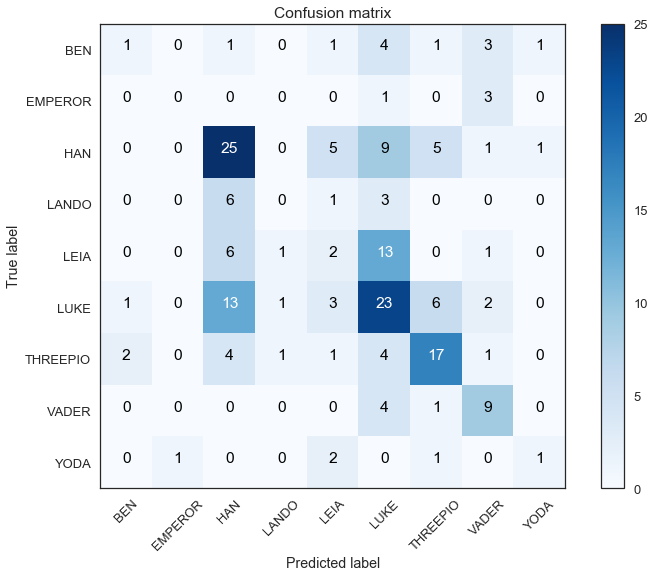

In [58]:
plot_confusion_matrix(cm, sgd.classes_, False);
plt.gcf().set_size_inches(12,12)

# confusion matrix

Normalized confusion matrix


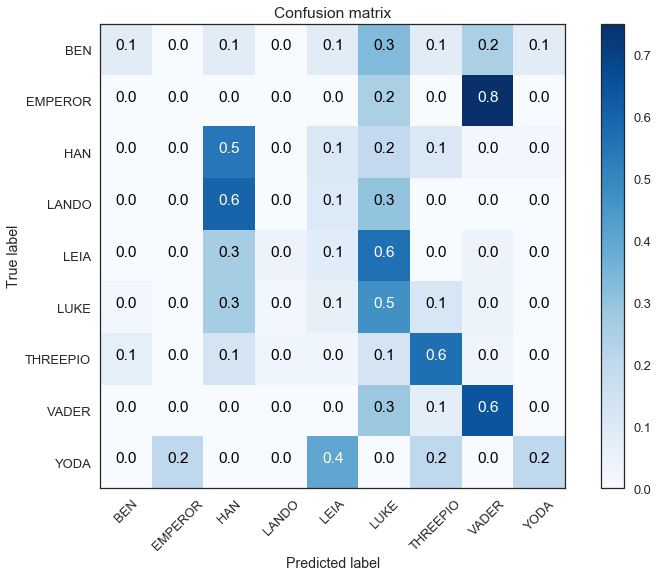

In [59]:
plot_confusion_matrix(cm, sgd.classes_, True);
plt.gcf().set_size_inches(12,12)

# evaluating predictions

In [60]:
evaldf=pd.DataFrame({'X_test': X_test, 'y_test': y_test, 'prediction': prediction})
evaldf.head(20)

,X_test,y_test,prediction
380,but there got ta be something you can do,LUKE,LUKE
643,i only wish ben were here,LUKE,LUKE
578,only a master of evil darth,BEN,THREEPIO
1230,having trouble with you droid,LANDO,LUKE
1217,well i do trust him either but he is my friend...,HAN,THREEPIO
529,hurry,THREEPIO,THREEPIO
485,there is any other way out,LUKE,HAN
1746,yes artoo i was just coming to that,THREEPIO,LUKE
1606,you gon na need it,HAN,HAN
1146,i thought you knew this person,LEIA,HAN
